In [307]:
import pandas as pd
import pylab as pl
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [348]:
dfold=pd.read_csv('seg_taxi.csv')

In [369]:
dftraffic=pd.read_csv('https://data.cityofnewyork.us/api/views/p424-amsu/rows.csv')

In [349]:
dfold.counts.sum()

995

In [365]:
df=pd.read_csv('seg_taxi_merged.csv')

In [367]:
df=df.rename(columns={'0':'counts'})
df=df.drop('Unnamed: 0',1)

In [368]:
df.counts.sum()

3033

In [370]:
detectors=df.SegmentID.unique()

In [371]:
dftraffic['SegmentID']=dftraffic['Segment ID']

In [372]:
dfred=dftraffic[dftraffic.SegmentID.isin(detectors)]

In [373]:
dfred.Date=pd.to_datetime(dfred.Date)
dfred['Day']=dfred.Date.dt.day

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [358]:
dfred=dfred[(dfred.Date.dt.month==10)&(dfred.Date.dt.day<=7)&(dfred.Date.dt.day>=1)]

In [374]:
loop=[]
for i in range(0,len(df)):
    segment=df.iloc[i,0]
    hour=df.iloc[i,1]
    day=df.iloc[i,3]
    for j in range(0,len(dfred)):
        if ((dfred.iloc[j,1]==segment)&(dfred.iloc[j,32]==day)):
            counts=dfred.iloc[j,7+hour]
            loop.append([segment,day,hour,counts])
            break

In [375]:
dfloop=pd.DataFrame(loop)

In [376]:
dfloop=dfloop.rename(columns={0:'SegmentID',1:'day',2:'hour',3:'loop_count'})

In [377]:
dfcounts=df.merge(dfloop,on=['SegmentID','hour','day'])

In [378]:
dfcounts=dfcounts.sort_values(['day','hour'])

In [379]:
dfcounts=dfcounts.reset_index()
dfcounts=dfcounts.drop('index',1)

In [438]:
dfcounts[dfcounts.hour==1].loop_count.sum()

26418.0

In [ ]:
hrcount=[]
for i in range(0,24):
    hrcount.append(dfcounts[dfcounts.hour==i].counts.sum())

In [490]:
loophrcount=[]
for i in range(0,24):
    loophrcount.append(dfcounts[dfcounts.hour==i].loop_count.sum())

In [491]:
dfhrcount=pd.DataFrame(hrcount)
dfloophrcount=pd.DataFrame(loophrcount)
dfhrcounts=pd.concat([dfhrcount,dfloophrcount],axis=1)

In [492]:
dfhrcounts.columns=['taxihr_counts','loophr_counts']

In [498]:
hrid=pd.DataFrame(np.identity(24))
for i in range(0,24):
    hrid=hrid.rename(columns={i:'x'+str(i)})

In [499]:
hrid.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [504]:
dfhrcounts=pd.concat([dfhrcounts,hrid],axis=1)

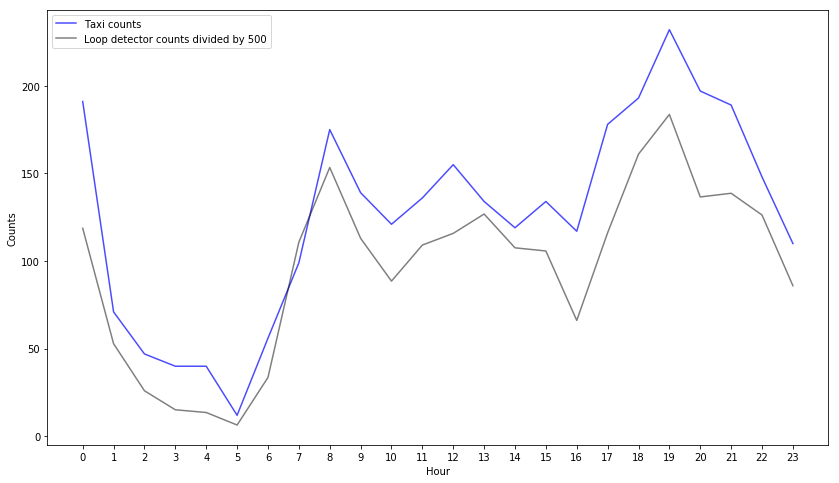

In [587]:
pl.plot(dfhrcounts.taxihr_counts,'b',alpha=0.7)
pl.plot(dfhrcounts.loophr_counts/500,'k',alpha=0.5)
pl.xticks(range(0,24));
pl.xlabel('Hour')
pl.ylabel('Counts')
pl.legend(['Taxi counts','Loop detector counts divided by 500']);

In [457]:
#figsize(14,8)
#pl.plot(dfcounts.counts)
#pl.plot(dfcounts.loop_count/500)
#pl.xlim(0,400)

In [458]:
workday=[]
hourflag=np.zeros([len(dfcounts),24])
hours=range(0,24)
days=range(1,8)
for i in range(0,len(dfcounts)):
    if (dfcounts.iloc[i,3]<=5):
        flag=1
    else: 
        flag=0
    workday.append(flag)
    for j in range(0,len(hours)):
        if dfcounts.iloc[i,1]==hours[j]:
            hourflag[i,j]=1

In [459]:
dfcounts=pd.concat([dfcounts,pd.DataFrame(hourflag)],axis=1)

In [460]:
dfcounts['workday']=workday

In [461]:
for i in range(0,24):
    dfcounts=dfcounts.rename(columns={i:'x'+str(i)})

In [ ]:
#x0+x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15+x16+x17+x18+x19+x20

In [597]:
lmhr=smf.ols('loophr_counts ~ taxihr_counts-1', dfhrcounts).fit()

In [598]:
lmhr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          loophr_counts   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1117.
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           5.32e-21
Time:                        13:38:38   Log-Likelihood:                -248.67
No. Observations:                  24   AIC:                             499.3
Df Residuals:                      23   BIC:                             500.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
taxihr_counts   384.1464     11.494     33.422      0.000       360.370   407.923
==============================================================================
Omnibus:                        0.504   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.506
Skew:                           0.298   Prob(JB):                        0.776
Kurtosis:                       2.612   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

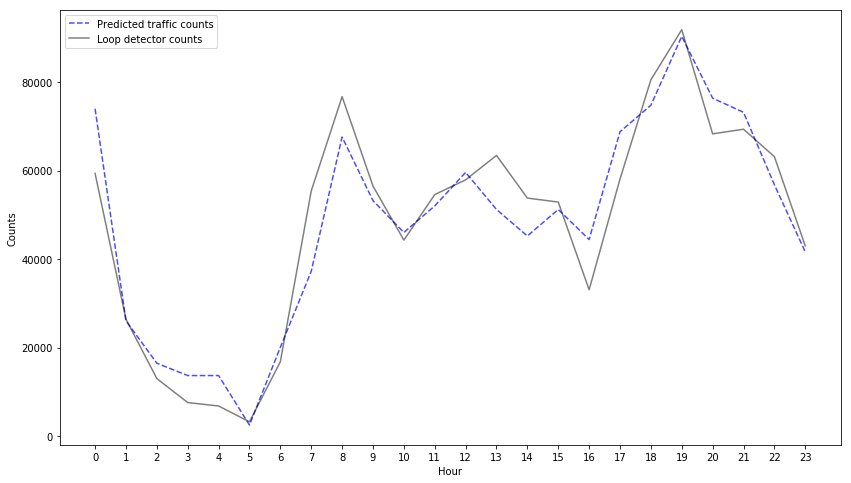

In [596]:
pl.plot(lmhr.predict(),'--',color='b',alpha=0.7)
pl.plot(dfhrcounts.loophr_counts,'k',alpha=0.5)
pl.xticks(range(0,24));
pl.xlabel('Hour')
pl.ylabel('Counts')
pl.legend(['Predicted traffic counts','Loop detector counts']);

In [ ]:
#x0+x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15+x16+x17+x18+x19+x20+x21+x22+x23

In [507]:
#Y=dfcounts.loop_count
#X=dfcounts.counts
lm=smf.ols('loop_count ~ counts+workday+x0+x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15+x16+x17+x18+x19+x20+x21+x22+x23', dfcounts).fit()

In [468]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loop_count   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     9.388
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           2.27e-32
Time:                        11:27:48   Log-Likelihood:                -9384.7
No. Observations:                1211   AIC:                         1.882e+04
Df Residuals:                    1185   BIC:                         1.895e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    978.0520     33.081     29.565      0.000       913.148  1042.956
counts       -77.9170      7.147    -10.903      0.000       -91.938   -63.896
workday        4.7510     37.109      0.128      0.898       -68.056    77.558
x0[0]        128.4667     36.551      3.515      0.000        56.755   200.178
x0[1]        128.4667     36.551      3.515      0.000        56.755   200.178
x1[0]         -6.0132     48.370     -0.124      0.901      -100.913    88.887
x1[1]         -6.0132     48.370     -0.124      0.901      -100.913    88.887
x2[0]       -111.3137     58.924     -1.889      0.059      -226.920     4.293
x2[1]       -111.3137     58.924     -1.889      0.059      -226.920     4.293
x3[0]       -175.3444     66.897     -2.621      0.009      -306.593   -44.096
x3[1]       -175.3444     66.897     -2.621      0.009      -306.593   -44.096
x4[0]       -242.0592     61.740     -3.921      0.000      -363.192  -120.926
x4[1]       -242.0592     61.740     -3.921      0.000      -363.192  -120.926
x5[0]       -230.4479     96.841     -2.380      0.017      -420.447   -40.449
x5[1]       -230.4479     96.841     -2.380      0.017      -420.447   -40.449
x6[0]       -125.7659     51.410     -2.446      0.015      -226.630   -24.902
x6[1]       -125.7659     51.410     -2.446      0.015      -226.630   -24.902
x7[0]        179.8994     41.228      4.364      0.000        99.012   260.787
x7[1]        179.8994     41.228      4.364      0.000        99.012   260.787
x8[0]        183.0051     34.836      5.253      0.000       114.658   251.352
x8[1]        183.0051     34.836      5.253      0.000       114.658   251.352
x9[0]         79.5941     36.732      2.167      0.030         7.527   151.661
x9[1]         79.5941     36.732      2.167      0.030         7.527   151.661
x10[0]        25.8266     38.841      0.665      0.506       -50.379   102.032
x10[1]        25.8266     38.841      0.665      0.506       -50.379   102.032
x11[0]       135.7377     38.931      3.487      0.001        59.355   212.120
x11[1]       135.7377     38.931      3.487      0.001        59.355   212.120
x12[0]        73.5272     35.823      2.053      0.040         3.244   143.811
x12[1]        73.5272     35.823      2.053      0.040         3.244   143.811
x13[0]       104.9465     35.761      2.935      0.003        34.784   175.109
x13[1]       104.9465     35.761      2.935      0.003        34.784   175.109
x14[0]        62.5450     37.178      1.682      0.093       -10.398   135.488
x14[1]        62.5450     37.178      1.682      0.093       -10.398   135.488
x15[0]        95.6925     38.153      2.508      0.012        20.837   170.548
x15[1]        95.6925     38.153      2.508      0.012        20.837   170.548
x16[0]       -11.6822     42.238     -0.277      0.782       -94.552    71.188
x1

26418.0

In [473]:
len(dfcounts)

1211

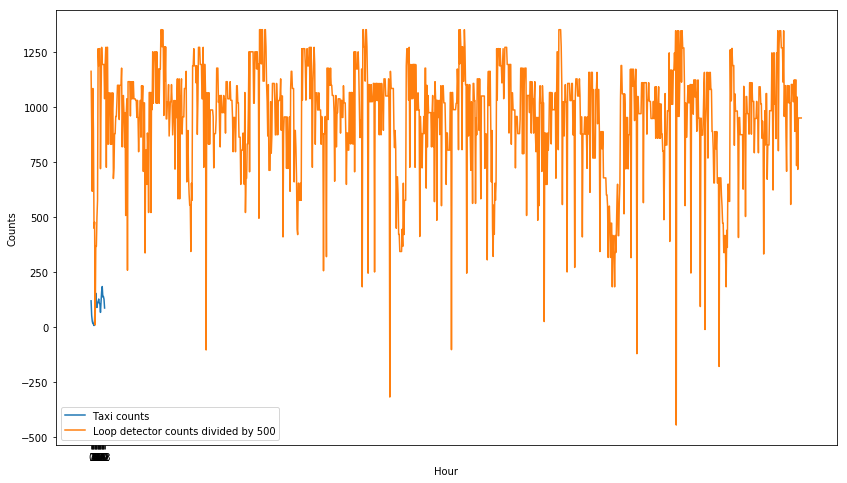

In [464]:
pl.plot(loophrcount)
pl.plot(lm.predict())
pl.xticks(range(0,24));
pl.xlabel('Hour')
pl.ylabel('Counts')
pl.legend(['Taxi counts','Loop detector counts divided by 500'])

(0, 100)

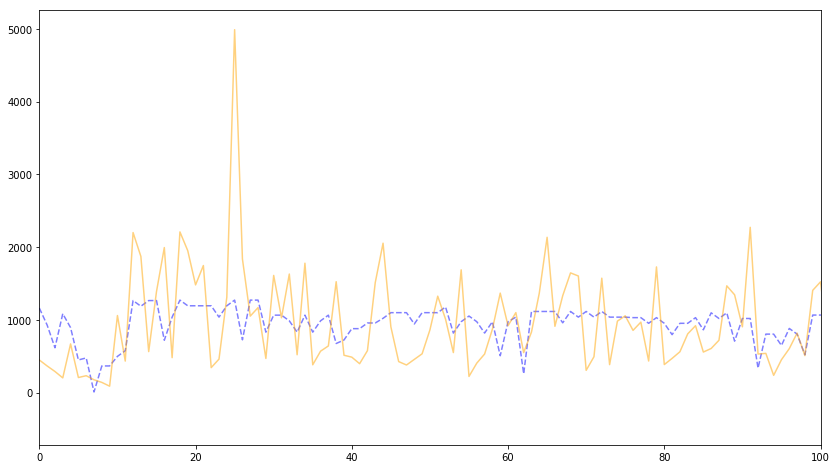

In [389]:
figsize(14,8)
pl.plot(lm.predict(),'--',color='b',alpha=.5)
pl.plot(dfcounts.loop_count,color='orange',alpha=.5)
pl.xlim(0,100)

In [306]:
dfloop.groupby(['day','hour']).sum()

SegmentID  loop_count
day hour                       
1   2         32807       207.0
    6        192510      1492.0
    8        106192      3367.0
    9        167825      5473.0
    10        67904       884.0
    11       243552      7142.0
    12        68049       752.0
    13       201706      6537.0
    14        68197      1031.0
    15       158858       904.0
    16       170358      2649.0
    18       362853      6442.0
    19       102454      1851.0
    20       131881      4715.0
    21       172124      3179.0
    22       298454      3092.0
    23        33121      1382.0
2   1         68197       313.0
    2         33471       348.0
    3         33121       396.0
    7        293562      6711.0
    8        451655      8602.0
    9        270826      6321.0
    10       227981      4552.0
    11        66419      1455.0
    12       358210      6352.0
    13        66860      2093.0
    14       168047      5528.0
    15       134093      3393.0
    16       136101      1950.0
...             ...         ...
6   13       168078      4750.0
    14       202786      8464.0
    15       395609      8953.0
    16        68197      1113.0
    17       136302      3453.0
    18       292907      7075.0
    19       202791      4435.0
    20       202630      6100.0
    21        32775      1263.0
    22       170304      8852.0
    23       100711      1431.0
7   0         98496      5188.0
    1         66945      1423.0
    2        133595      2291.0
    3        158858       470.0
    4        102425      2764.0
    6         34027       198.0
    8        101931       812.0
    10        99839      1487.0
    11        34257       516.0
    12       101700      2378.0
    13        32807       530.0
    14       293563      4407.0
    15       328558      3317.0
    16        32807       614.0
    17       417890      4202.0
    18        99234      2873.0
    19       191762      1481.0
    20        68197       948.0
    23        34654      1112.0

[139 rows x 2 columns]